In [1]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
import utils
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Ridge
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
import warnings
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from collections import Counter
plt.rcParams['figure.figsize'] = (17, 5)

In [2]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')

# Load metadata and features.
tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [3]:

columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast']
for column in columns:
    print(column + ":\n")
    ipd.display(features[column].head().style.format('{:.2f}'))

mfcc:



chroma_cens:



tonnetz:



spectral_contrast:



In [4]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
test = (tracks['set', 'split'] == 'test') | (tracks['set', 'split'] == 'validation')
y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]

X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test, 'mfcc']


print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

6400 training examples, 1600 testing examples
140 features, 8 classes


(1600, 140) (1600,)
LR :

Accuracy: 44.94%


F1 Score: 
44.52607031577631


Recall Score: 
44.9375


Precision Score: 
44.37767385706559




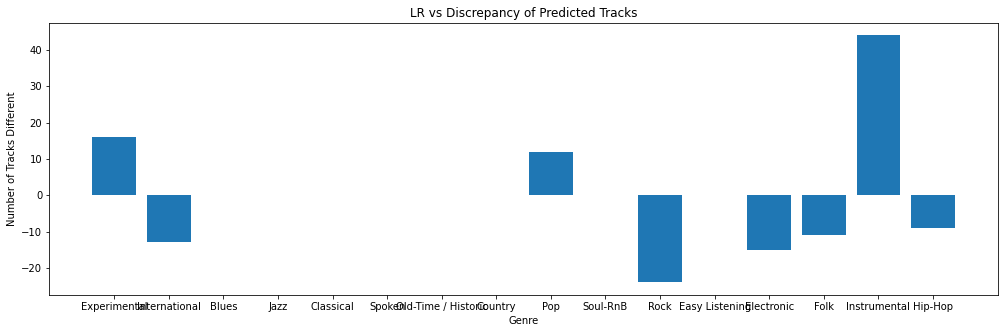

Average Discrepancy: 9.0
kNN :

Accuracy: 40.69%


F1 Score: 
36.748243449716405


Recall Score: 
40.6875


Precision Score: 
42.22590766117166




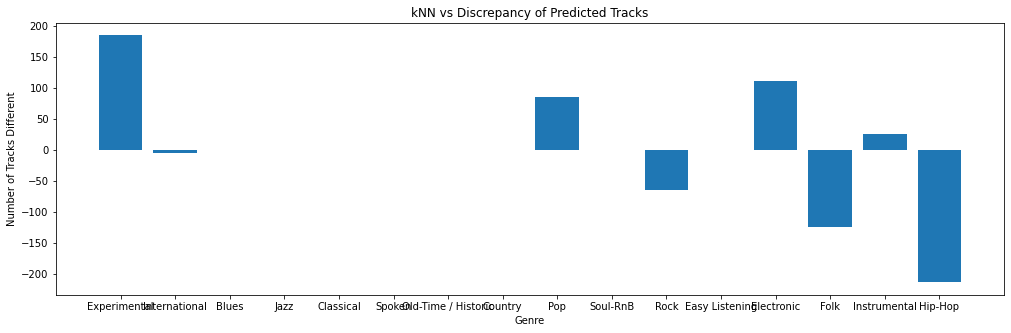

Average Discrepancy: 51.0
SVCrbf :

Accuracy: 49.75%


F1 Score: 
49.26936035269999


Recall Score: 
49.75000000000001


Precision Score: 
49.764432931763395




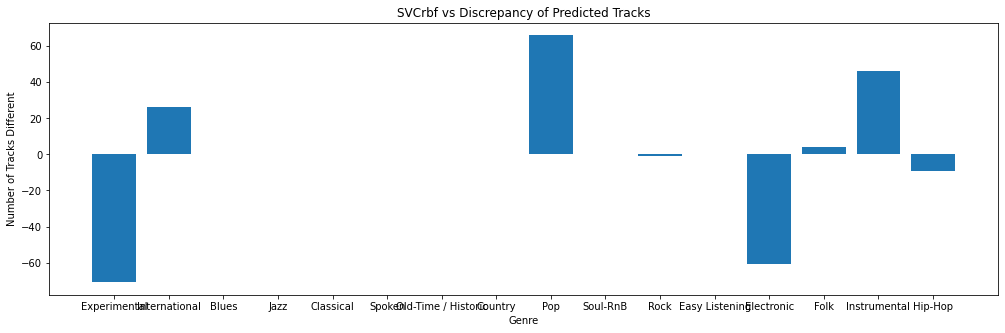

Average Discrepancy: 17.75
SVCpoly1 :

Accuracy: 45.19%


F1 Score: 
44.64439541571211


Recall Score: 
45.1875


Precision Score: 
44.39464062387268




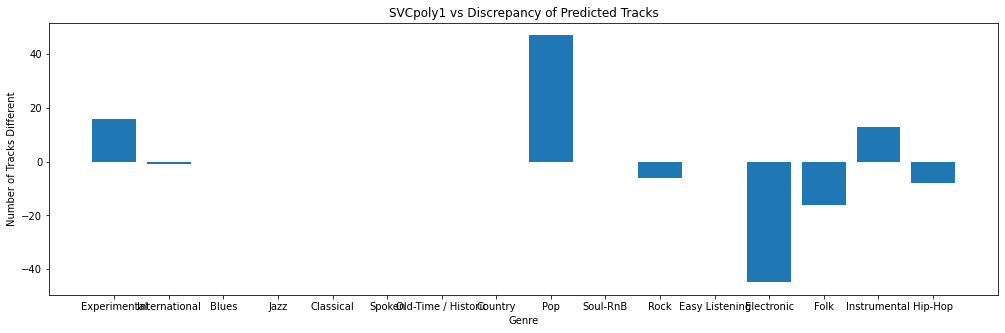

Average Discrepancy: 9.5
linSVC1 :

Accuracy: 43.88%


F1 Score: 
43.65862641897108


Recall Score: 
43.875


Precision Score: 
43.839013409238156




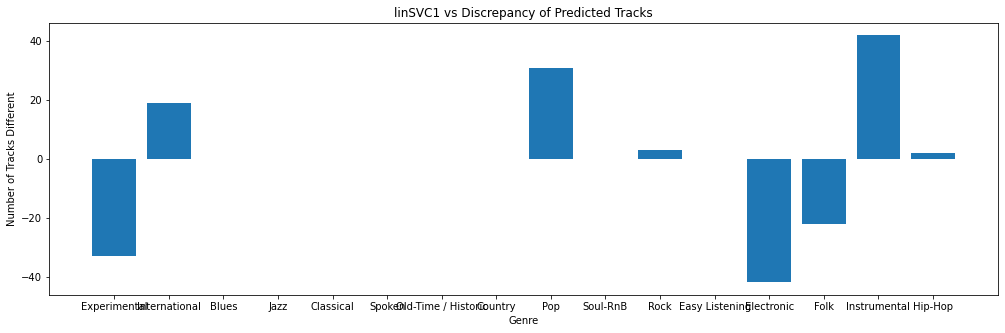

Average Discrepancy: 12.125
linSVC2 :

Accuracy: 46.12%


F1 Score: 
44.66663396993995


Recall Score: 
46.125


Precision Score: 
44.5318434019474




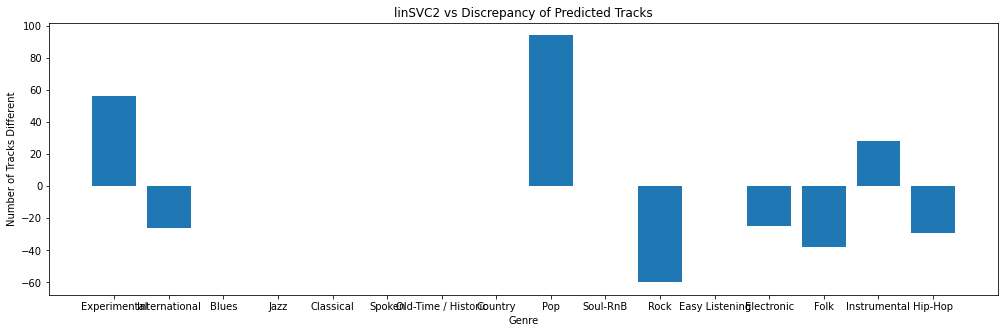

Average Discrepancy: 22.25
DT :

Accuracy: 31.00%


F1 Score: 
28.589188581644702


Recall Score: 
31.000000000000007


Precision Score: 
29.88697337625294




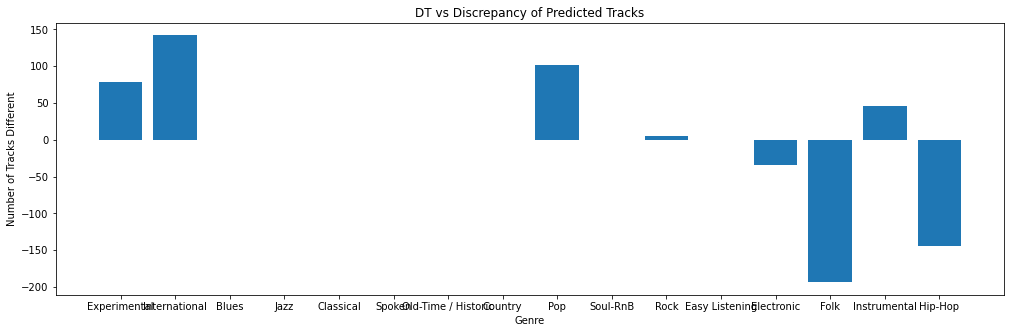

Average Discrepancy: 46.625
RF :

Accuracy: 38.12%


F1 Score: 
34.76964963859797


Recall Score: 
38.125


Precision Score: 
35.090133000781634




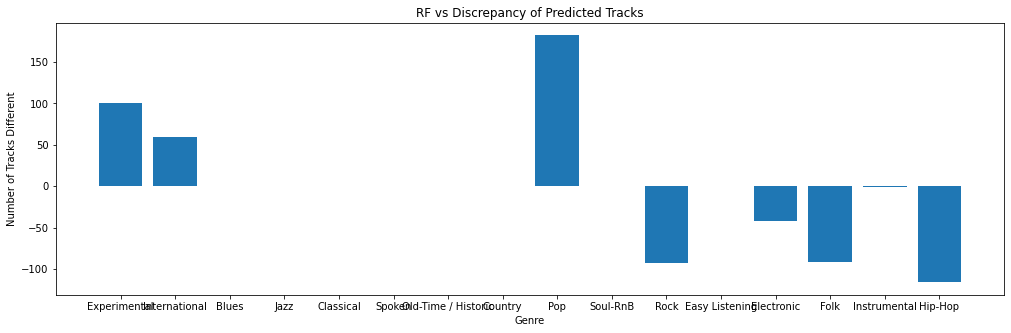

Average Discrepancy: 42.75
NB :

Accuracy: 40.75%


F1 Score: 
38.37129434415334


Recall Score: 
40.75


Precision Score: 
39.575232826514736




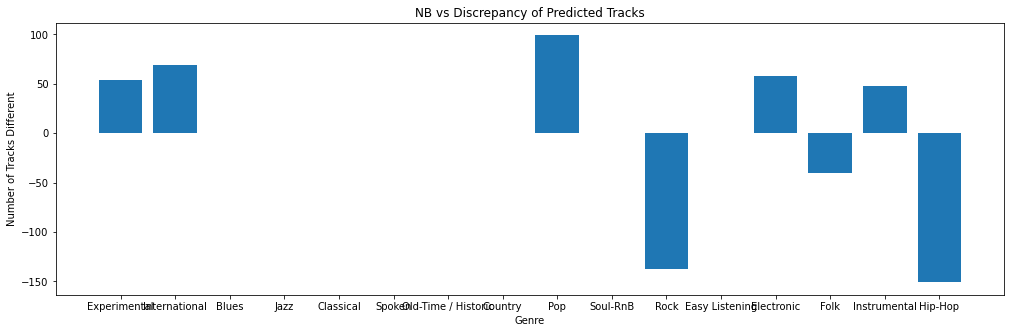

Average Discrepancy: 41.0
QDA :

Accuracy: 42.44%


F1 Score: 
41.55128939910061


Recall Score: 
42.43749999999999


Precision Score: 
41.30759666286071




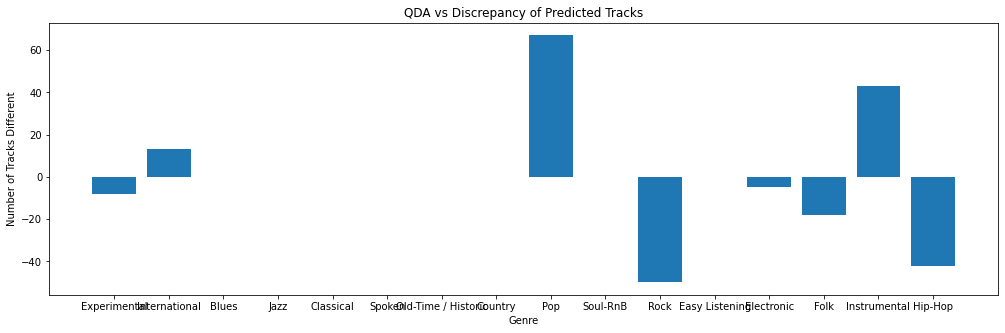

Average Discrepancy: 15.375
LDA :

Accuracy: 46.31%


F1 Score: 
46.06287218429701


Recall Score: 
46.3125


Precision Score: 
46.045888192803844




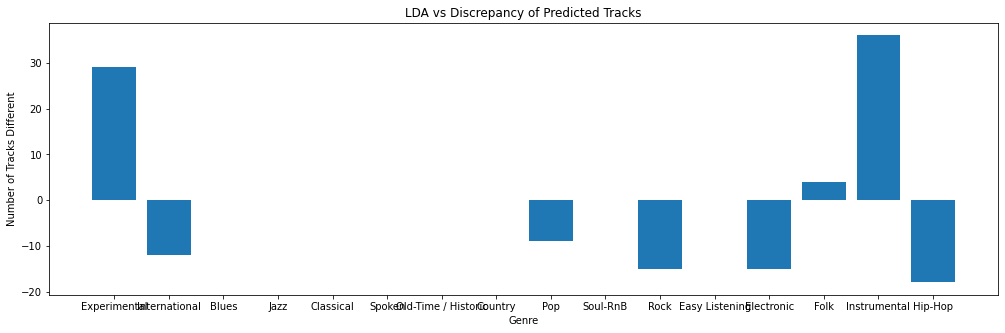

Average Discrepancy: 8.625


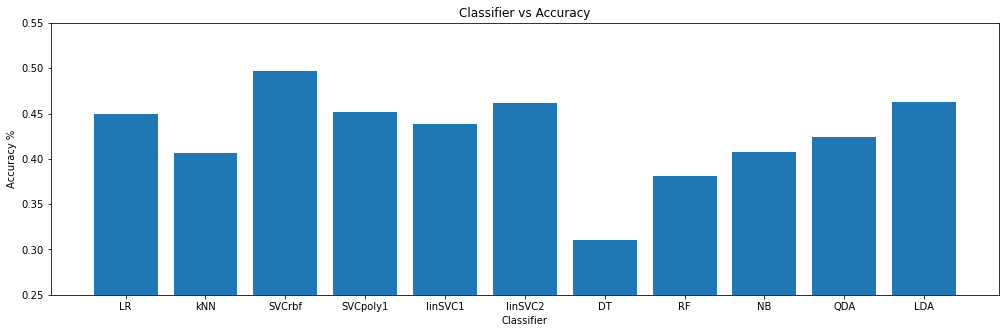

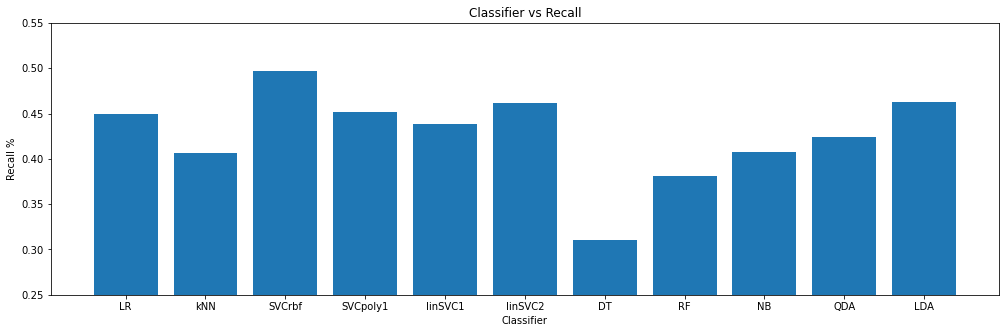

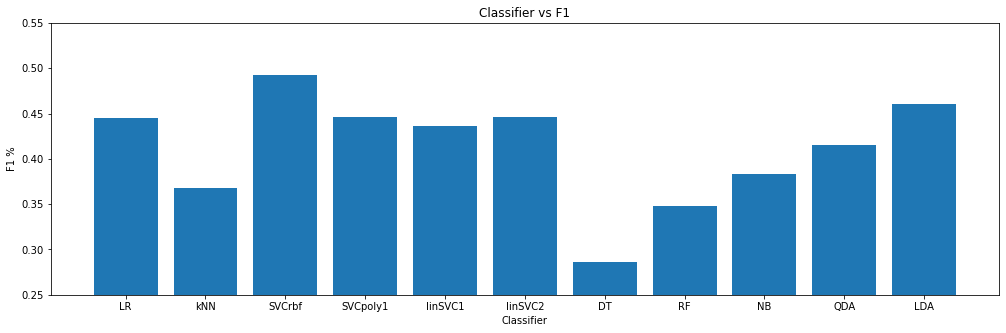

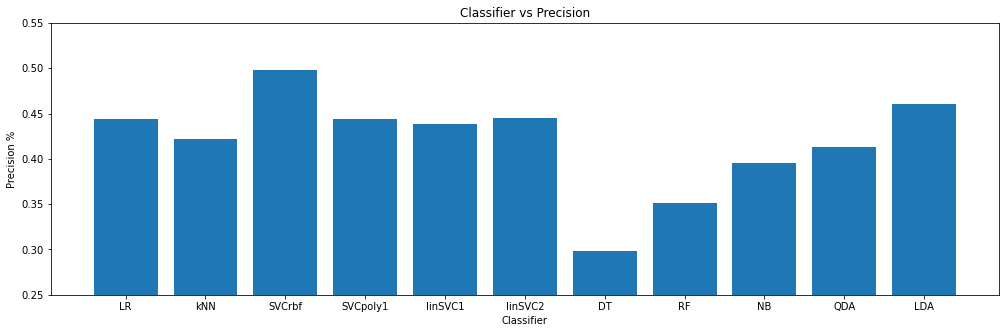

In [7]:
# Be sure training samples are shuffled.
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

    # Standardize features by removing the mean and scaling to unit variance.
    scaler = skl.preprocessing.StandardScaler(copy=False)
    scaler.fit_transform(X_train)
    scaler.transform(X_test)
    
    y_test = np.array(y_test)
    y_test = y_test.T
    print(X_test.shape, y_test.shape)
    #classification models
    classifiers = {
        'LR': LogisticRegression(max_iter=10000),
        'kNN': KNeighborsClassifier(n_neighbors=200),
        'SVCrbf': SVC(kernel='rbf'),
        'SVCpoly1': SVC(kernel='poly', degree=1),
        'linSVC1': SVC(kernel="linear"),
        'linSVC2': LinearSVC(),
        'DT': DecisionTreeClassifier(max_depth=5),
        'RF': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        'NB': GaussianNB(),
        'QDA': QuadraticDiscriminantAnalysis(),
        'LDA': LinearDiscriminantAnalysis()
     }
    classifier_list=[]
    accuracy_list=[]
    prec_list=[]
    rec_list = []
    f1_list=[]
    genre_list_test = genres.loc[genres['top_level'].unique()].title
    genre_list =[]
    y_test_categories = []
    for genre in genre_list_test:
        genre_list.append(genre)
    y_test_categories = Counter(y_test)
    #Go through each classifier and calculate preicted and graph
    for key in classifiers:
            y_pred_categories = []
            genre_val = []
            avg = 0
            count = 0
            classifier = classifiers[key]
            classifier.fit(X_train, y_train)
            pred = classifier.predict(X_test)
            y_pred_categories = Counter(pred)
            for genre in genre_list:
                genre_val.append(y_test_categories[genre]- y_pred_categories[genre])
                avg += abs(genre_val[count])
                count+=1
            avg = avg /len(genre_val)
            f1 = f1_score(y_test, pred, average = None)
            f1 = sum(f1)/len(f1)
            score = classifier.score(X_test, y_test)
            prec_score = precision_score(y_test, pred, average = None)
            prec_score = sum(prec_score)/len(prec_score)
            rec = recall_score(y_test, pred, average = None)
            rec = sum(rec)/len(rec)
            print(key + " :\n")
            print('Accuracy: {:.2%}'.format(score))
            print("\n")
            print("F1 Score: ")
            print(f1*100)
            print("\n")
            print("Recall Score: ")
            print(rec*100)
            print("\n")
            print("Precision Score: ")
            print(prec_score*100)
            print("\n")
            classifier_list.append(key)
            accuracy_list.append(score)
            prec_list.append(prec_score)
            rec_list.append(rec)
            f1_list.append(f1)

            plt.bar(genre_list, genre_val)
            plt.title(f'{key} vs Discrepancy of Predicted Tracks')
            plt.xlabel('Genre')
            plt.ylabel('Number of Tracks Different')
            plt.show()
            
            print("Average Discrepancy:", avg)
        
    plt.bar(classifier_list, accuracy_list)
    plt.title('Classifier vs Accuracy')
    plt.xlabel('Classifier')
    plt.ylabel('Accuracy %')
    plt.ylim([0.25, 0.55])
    plt.show()

    plt.bar(classifier_list, rec_list)
    plt.title('Classifier vs Recall')
    plt.xlabel('Classifier')
    plt.ylabel('Recall %')
    plt.ylim([0.25, 0.55])
    plt.show()

    plt.bar(classifier_list, f1_list)
    plt.title('Classifier vs F1')
    plt.xlabel('Classifier')
    plt.ylabel('F1 %')
    plt.ylim([0.25, 0.55])
    plt.show()

    plt.bar(classifier_list, prec_list)
    plt.title('Classifier vs Precision')
    plt.xlabel('Classifier')
    plt.ylabel('Precision %')
    plt.ylim([0.25, 0.55])
    plt.show()